In [17]:
import numpy as np

import scipy.signal as signal
import scipy.ndimage.filters as filters
import scipy.special as special
import scipy.optimize as optimize

import matplotlib.pyplot as plt

import skimage.io
import skimage.transform

import cv2

import svm 
import svmutil

In [18]:
def generalized_gaussian_dist(x, m, alpha, sigma):
    def beta():
        return sigma * np.sqrt(special.gamma(1 / alpha) / special.gamma(3 / alpha))
    
    coefficient = alpha / (2 * beta() * special.gamma(1 / alpha))
    return m * coefficient * np.exp(-(np.abs(x) / beta()) ** alpha)


def asymmetric_generalized_gaussian_dist(x, m, nu, sigma_l, sigma_r):
    def beta(sigma):
        return sigma * np.sqrt(special.gamma(1 / nu) / special.gamma(3 / nu))
    
    coefficient = nu / ((beta(sigma_l) + beta(sigma_r)) * special.gamma(1 / nu))
    f = lambda x, sigma: m * coefficient * np.exp(-(x / beta(sigma)) ** nu)
        
    return np.where(x < 0, f(-x, sigma_l), f(x, sigma_r))


def asymmetric_generalized_gaussian_fit(x):
    def estimate_phi(alpha):
        numerator = special.gamma(2 / alpha) ** 2
        denominator = special.gamma(1 / alpha) * special.gamma(3 / alpha)
        return numerator / denominator

    def estimate_r_hat(x):
        size = np.prod(x.shape)
        return (np.sum(np.abs(x)) / size) ** 2 / (np.sum(x ** 2) / size)

    def estimate_R_hat(r_hat, gamma):
        numerator = (gamma ** 3 + 1) * (gamma + 1)
        denominator = (gamma ** 2 + 1) ** 2
        return r_hat * numerator / denominator

    def mean_squares_sum(x, filter = lambda z: z == z):
        filtered_values = x[filter(x)]
        squares_sum = np.sum(filtered_values ** 2)
        return squares_sum / ((filtered_values.shape))

    def estimate_gamma(x):
        left_squares = mean_squares_sum(x, lambda z: z < 0)
        right_squares = mean_squares_sum(x, lambda z: z >= 0)

        return np.sqrt(left_squares) / np.sqrt(right_squares)

    def estimate_alpha(x):
        r_hat = estimate_r_hat(x)
        gamma = estimate_gamma(x)
        R_hat = estimate_R_hat(r_hat, gamma)

        solution = optimize.root(lambda z: estimate_phi(z) - R_hat, [0.2]).x

        return solution[0]

    def estimate_beta(x, alpha, filter = lambda z: z < 0):
        first_product = np.sqrt(mean_squares_sum(x, filter))
        second_product =np.sqrt(special.gamma(3 / alpha) / special.gamma(1 / alpha))

        return  first_product
        # Authoris don't multiply the second product
        # return  first_product * second_product 
    
    alpha = estimate_alpha(x)
    beta_l = estimate_beta(x, alpha, lambda z: z < 0)
    beta_r = estimate_beta(x, alpha, lambda z: z >= 0)
    
    return alpha, beta_l, beta_r


def generalized_gaussian_fit(x):
    alpha, beta_l, beta_r = asymmetric_generalized_gaussian_fit(x)
    return alpha, np.sqrt((beta_l ** 2 + beta_r ** 2) / 2)

def fit_distribution(x, density_function, bins=250):
    n, bins = np.histogram(x.ravel(), bins)
    normalized_freq = n / np.max(n)
    
    params, _ = optimize.curve_fit(density_function, bins[:-1], normalized_freq)
    
    return params

In [19]:
def normalize_kernel(kernel):
    """Normalization is defined as the division of each element in the kernel by the sum of all kernel elements, 
    so that the sum of the elements of a normalized kernel is one. This will ensure the average pixel in the modified
    image is as bright as the average pixel in the original image. """
    return kernel / np.sum(kernel)

def gaussian_kernel_2d(n, sigma):
    Y, X = np.indices((n, n)) - int(n/2)
    gaussian_kernel = 1 / (2 * np.pi * sigma ** 2) * np.exp(-(X ** 2 + Y ** 2) / (2 * sigma ** 2)) 
    return normalize_kernel(gaussian_kernel)

def low_pass_kernel_2d(dimension):
    return normalize_kernel(np.ones(dimension))

def low_pass_filter_2d(image):
    kernel = low_pass_kernel_2d((3, 3))
    return signal.convolve2d(image, kernel, 'same')

def local_variance(image, local_mean, kernel):
    sigma = signal.convolve2d(image ** 2, kernel, 'same')
    diff = np.abs(local_mean ** 2 - sigma)
    return np.sqrt(diff)

def calculate_mean_substracted_constrast_normalized_coefficients(image, kernel_size=3, sigma=3):
    C = 1/255
    kernel = gaussian_kernel_2d(kernel_size, sigma=sigma)
    local_mean = signal.convolve2d(image, kernel, 'same')
    local_var = local_variance(image, local_mean, kernel)
    
    return (image - local_mean) / (local_var + C)

def calculate_pair_product_coefficients(mscn_coefficients):
    return {
        'horizontal': mscn_coefficients[:, :-1] * mscn_coefficients[:, 1:],
        'vertical': mscn_coefficients[:-1, :] * mscn_coefficients[1:, :],
        'main_diagonal': mscn_coefficients[:-1, :-1] * mscn_coefficients[1:, 1:],
        'secondary_diagonal': mscn_coefficients[1:, :-1] * mscn_coefficients[:-1, 1:]
    }

def calculate_brisque_coefficients(image, kernel_size=3, sigma=3):
    mscn_coeff = calculate_mean_substracted_constrast_normalized_coefficients(image, kernel_size, sigma)
    pair_prod_coeff = calculate_pair_product_coefficients(mscn_coeff)
    
    return dict(**pair_prod_coeff, **{'mscn': mscn_coeff})


def calculate_mscn_features(coefficients):
    alpha, sigma = generalized_gaussian_fit(coefficients)
    return [alpha, sigma ** 2]
    

def calculate_pair_product_features(coefficients):
    alpha, sigma_l, sigma_r = asymmetric_generalized_gaussian_fit(coefficients)
    constant = np.sqrt(special.gamma(1 / alpha) / special.gamma(3 / alpha))
    mean = (sigma_r - sigma_l) * constant * (special.gamma(2 / alpha) / special.gamma(1 / alpha))
    return [alpha, mean, sigma_l ** 2, sigma_r ** 2]


def calculate_brisque_features(image, kernel_size=3, sigma=3):
    features = []
    
    coefficients = calculate_brisque_coefficients(image, kernel_size, sigma)
    mscn_features = calculate_mscn_features(coefficients['mscn'])
    
    feature_order = ['horizontal', 'vertical', 'main_diagonal', 'secondary_diagonal']
    
    for label in feature_order:
        features = features + calculate_pair_product_features(coefficients[label])
    
    return np.array(mscn_features + features)

def normalize_features(features):
    x = []
    
    min_= [0.336999 ,0.019667 ,0.230000 ,-0.125959 ,0.000167 ,0.000616 ,0.231000 ,
           -0.125873 ,0.000165 ,0.000600 ,0.241000 ,-0.128814 ,0.000179 ,0.000386 ,
           0.243000 ,-0.133080 ,0.000182 ,0.000421 ,0.436998 ,0.016929 ,0.247000 ,
           -0.200231 ,0.000104 ,0.000834 ,0.257000 ,-0.200017 ,0.000112 ,0.000876 ,
           0.257000 ,-0.155072 ,0.000112 ,0.000356 ,0.258000 ,-0.154374 ,0.000117 ,0.000351]
    max_= [9.999411, 0.807472, 1.644021, 0.202917, 0.712384, 0.468672, 1.644021, 0.169548, 
           0.713132, 0.467896, 1.553016, 0.101368, 0.687324, 0.533087, 1.554016, 0.101000, 
           0.689177, 0.533133, 3.639918, 0.800955, 1.096995, 0.175286, 0.755547, 0.399270, 
           1.095995, 0.155928, 0.751488, 0.402398, 1.041992, 0.093209, 0.623516, 0.532925, 
           1.042992, 0.093714, 0.621958, 0.534484]
   
    for i in range(0, 36):
        x.append(-1 + (2.0 / (max_[i] - min_[i]) * (features[i] - min_[i])))
    
    return np.array(x)


def calculate_brisque_quality_score(image=None, normalized_brisque_features=None, kernel_size=3, sigma=3):
    assert image is not None or normalized_brisque_features is not None
    
    if image is not None:
        brisque_features = calculate_brisque_features(image, kernel_size, sigma)
        
#         downscaled_image = skimage.transform.downscale_local_mean(image, (2, 2))
        downscaled_image = cv2.resize(image, None, fx=1/2, fy=1/2, interpolation = cv2.INTER_CUBIC)
        downscale_brisque_features = calculate_brisque_features(downscaled_image, kernel_size, sigma)
        
        features = np.concatenate((brisque_features, downscale_brisque_features), axis=None)
        normalized_brisque_features = normalize_features(features)
    
    model = svmutil.svm_load_model('../models/brisque_svm.txt')
    
    x, idx = svmutil.gen_svm_nodearray(normalized_brisque_features, isKernel=(model.param.kernel_type == svmutil.PRECOMPUTED))
    nr_classifier = 1 # fixed for svm type as EPSILON_SVR (regression)
    prob_estimates = (svmutil.c_double * nr_classifier)()
    
    return svmutil.libsvm.svm_predict_probability(model, x, prob_estimates)

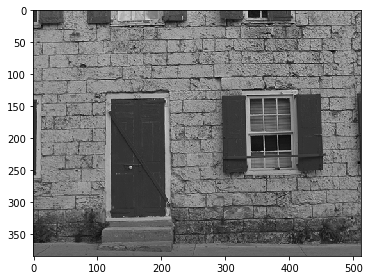

In [20]:
image = skimage.io.imread('../data/I01.BMP', as_gray=True)
skimage.io.imshow(image)

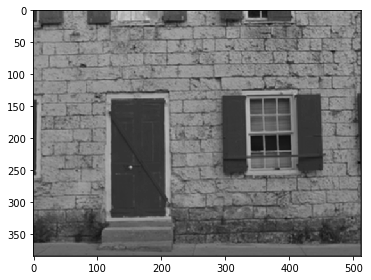

In [21]:
G = gaussian_kernel_2d(3, sigma=3)

local_mean_field = signal.convolve2d(image, G, 'same')
skimage.io.imshow(local_mean_field)

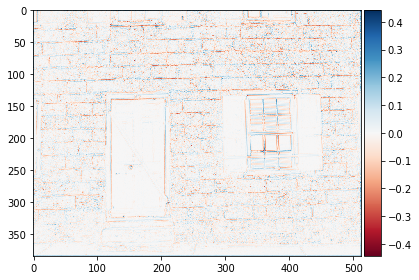

In [22]:
diff = image - local_mean_field
skimage.io.imshow(diff)

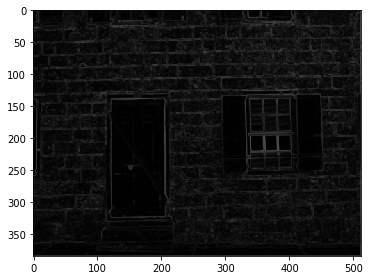

In [23]:
local_var = local_variance(image, local_mean_field, G)
skimage.io.imshow(local_var)

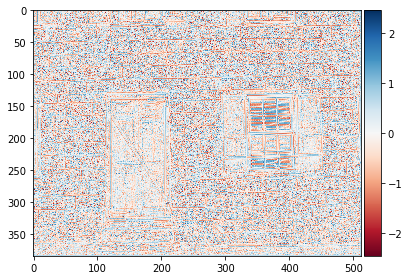

In [24]:
mscn_coefficients = calculate_mean_substracted_constrast_normalized_coefficients(image)
skimage.io.imshow(mscn_coefficients)

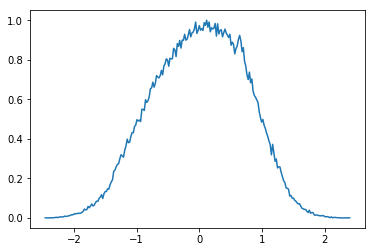

In [25]:
n, bins = np.histogram(mscn_coefficients.ravel(), bins=250)
n = n / np.max(n)
plt.plot(bins[:-1], n)

In [26]:
parameters = fit_distribution(mscn_coefficients, generalized_gaussian_dist)
print(parameters)

[1.95874629 2.79335018 0.7229647 ]


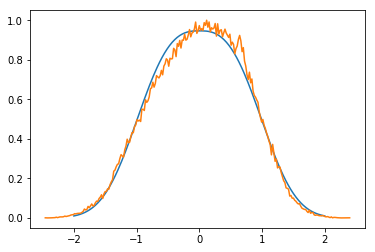

In [27]:
xdata = np.linspace(-2, 2, 200)
ydata = generalized_gaussian_dist(xdata, *parameters)
plt.plot(xdata, ydata)
plt.plot(bins[:-1], n)
plt.show()

In [28]:
coeff = calculate_pair_product_coefficients(mscn_coefficients)

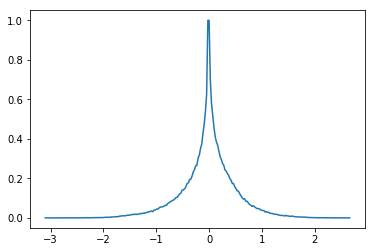

In [29]:
n, bins = np.histogram(coeff['vertical'].ravel(), bins=250)
n = n / np.max(n)
plt.plot(bins[:-1], n)

[0.46618535 0.59778557 0.75459467 0.75491686]


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in power
  


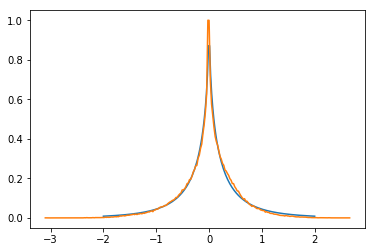

In [38]:
popt, pcov = optimize.curve_fit(asymmetric_generalized_gaussian_dist, bins[:-1], n / np.max(n))
xdata = np.linspace(-2, 2, 200)
print(popt)
ydata = asymmetric_generalized_gaussian_dist(xdata, *popt)
plt.plot(xdata, ydata)
plt.plot(bins[:-1], n)
plt.show()

In [39]:
def score(x):
    image = skimage.io.imread(x, as_gray=True)    
    return calculate_brisque_quality_score(image=image, kernel_size=7, sigma=7/6)

In [40]:
score('../data/I01_01_2.BMP')

42.56682373171449

In [33]:
reference_image_paths = ['../data/I{:02d}.BMP'.format(idx) for idx in range(1, 25)]
{image_file: score(image_file) for image_file in reference_image_paths}

{'../data/I01.BMP': 17.793787293109375,
 '../data/I02.BMP': 17.40443400946296,
 '../data/I03.BMP': 9.526058625452919,
 '../data/I04.BMP': 0.7067080539605683,
 '../data/I05.BMP': 0.3268583784921191,
 '../data/I06.BMP': 1.8516719035610265,
 '../data/I07.BMP': 25.326277562456056,
 '../data/I08.BMP': 3.8318206880596506,
 '../data/I09.BMP': 5.100218706625327,
 '../data/I10.BMP': 9.626224196780953,
 '../data/I11.BMP': 6.396607746089188,
 '../data/I12.BMP': 8.777016192476793,
 '../data/I13.BMP': 19.236487071010146,
 '../data/I14.BMP': 11.236748110638104,
 '../data/I15.BMP': -8.340252733201766,
 '../data/I16.BMP': -1.1391872424146925,
 '../data/I17.BMP': -0.8642153760650046,
 '../data/I18.BMP': 13.550975241632017,
 '../data/I19.BMP': 16.882467420712572,
 '../data/I20.BMP': 6.689841625479261,
 '../data/I21.BMP': 1.0091157931568375,
 '../data/I22.BMP': 7.301167290180587,
 '../data/I23.BMP': -13.181764672808555,
 '../data/I24.BMP': 8.46529862118345}

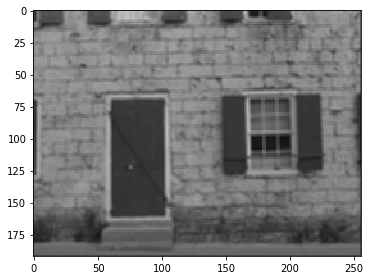

In [34]:
downscaled_image = skimage.transform.downscale_local_mean(image, (2,2))
low_pass_image = low_pass_filter_2d(downscaled_image)

skimage.io.imshow(low_pass_image)

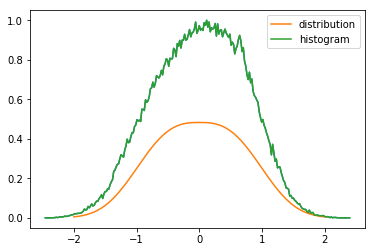

alpha: 2.7862304391969337, sigma: [0.52417975]


In [41]:
n, bins = np.histogram(mscn_coefficients.ravel(), bins=250)
n = n / np.max(n)
plt.plot(bins[:-1], n)

alpha, sigma = generalized_gaussian_fit(mscn_coefficients)

xdata = np.linspace(-2, 2, 200)
ydata = generalized_gaussian_dist(xdata, 1, alpha, sigma)
plt.plot(xdata, ydata, label='distribution')
plt.plot(bins[:-1], n, label='histogram')
plt.legend()
plt.show()

print('alpha: {}, sigma: {}'.format(alpha, sigma ** 2))

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in power
  


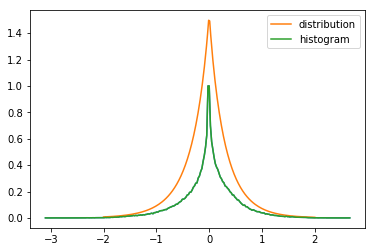

In [44]:
n, bins = np.histogram(coeff['vertical'].ravel(), bins=250)
n = n / np.max(n)
plt.plot(bins[:-1], n)

alpha, beta_l, beta_r =  asymmetric_generalized_gaussian_fit(coeff['vertical'])

xdata = np.linspace(-2, 2, 200)
ydata = asymmetric_generalized_gaussian_dist(xdata, 1, alpha, beta_l, beta_r)
plt.plot(xdata, ydata, label='distribution')
plt.plot(bins[:-1], n, label='histogram')
plt.legend()
plt.show()

In [45]:
sigma_l = np.sqrt(0.0311716)
sigma_r = np.sqrt(0.0385421)
alpha = 0.425998

constant = np.sqrt(special.gamma(1 / alpha) / special.gamma(3 / alpha))
mean = (sigma_r - sigma_l) * constant * (special.gamma(2 / alpha) / special.gamma(1 / alpha))
mean

0.009895628607173135

The image quality score is:  46.01136063940507


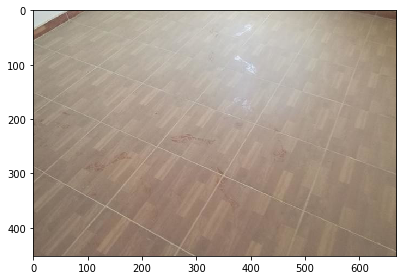

In [52]:
import urllib.request as request

url = 'https://www.propertyfinder.eg/property/1531159204/668/452/MODE/c6c087/384698-93f45o.jpg'
image_stream = request.urlopen(url)
image = skimage.io.imread(image_stream, plugin='pil')
skimage.io.imshow(image)
image = skimage.color.rgb2gray(image)
quality_score = calculate_brisque_quality_score(image=image, kernel_size=7, sigma=7/6)
print('The image quality score is: ', quality_score)

In [55]:
import scipy.io

In [65]:
mat = scipy.io.loadmat('../data/dmos.mat')
mat1 = scipy.io.loadmat('../data/refnames_all')

In [91]:
mat1['refnames_all'][0][1]

array(['studentsculpture.bmp'], dtype='<U20')